##### this notebook sets up our data

In [131]:
#import needed libraries
import kaggle
import numpy as np
import random
import matplotlib.pyplot as plt
import cv2 
import tqdm.notebook as tqdm
import torch
from torch.utils.data import Dataset, Subset
from torchvision.transforms import ToTensor, transforms
from PIL import Image
import os
import math
from collections import Counter, defaultdict
import copy

##### downloaded hasyv2 dataset from kaggle

In [2]:
if not os.path.exists('hasyv2'):
    os.environ['KAGGLE_CONFIG_DIR'] = os.path.expanduser('~/.kaggle')
    kaggle.api.dataset_download_files('guru001/hasyv2', path='hasyv2', unzip=True)
    print("Dataset downloaded and unzipped to: hasyv2/")

# FIXME

##### declared a dataset of type (tensor,label) where tensor is of type (1 , height, width)

In [25]:
class HasyV2Dataset(Dataset):
    def __init__(self, image_dir, labels_file, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        
        # Read and parse the labels file
        with open(labels_file, 'r') as f:
            lines = f.readlines()[1:]  # skip header line
        
        self.data = []
        for line in lines:
            parts = line.strip().split(',')
            if len(parts) >= 2:
                path = parts[0].strip()
                latex_symbol = parts[2].strip()  # This should be the LaTeX symbol
                
                # Clean path (remove duplicate hasy-data if present)
                clean_path = path.replace('hasy-data/', '').replace('hasy-data\\', '')
                full_path = os.path.join(self.image_dir, clean_path)
                
                if os.path.exists(full_path):
                    self.data.append((clean_path, latex_symbol))
                else:
                    print(f"Warning: Missing image {full_path}")

        print(f"Loaded {len(self.data)} samples with LaTeX labels")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, latex_label = self.data[idx]
        full_path = os.path.join(self.image_dir, img_path)
        
        try:
            img = Image.open(full_path).convert('L')  # Convert to grayscale
            if self.transform:
                img = self.transform(img)
            return img, latex_label
        except Exception as e:
            print(f"Error loading {full_path}: {str(e)}")
            # Return blank image and empty label if error occurs
            blank_img = Image.new('L', (32, 32), color=0)
            if self.transform:
                blank_img = self.transform(blank_img)
            return blank_img, ""

dataset = HasyV2Dataset(image_dir='hasyv2/hasy-data', 
                       labels_file='hasyv2/hasy-data-labels.csv', 
                       transform=None)

Loaded 168233 samples with LaTeX labels



LaTeX Label Verification:
Sample 71771:
  LaTeX label: \%
  Image size: (32, 32)


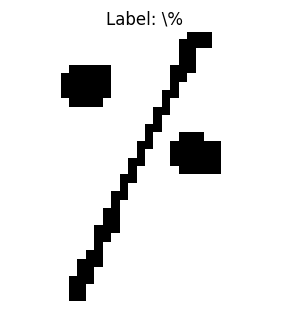

In [50]:
def verify_latex_labels(dataset, num_samples=1):
    print("\nLaTeX Label Verification:")
    indices = random.sample(range(len(dataset)), num_samples)
    for idx in indices:
        img, latex_label = dataset[idx]
        print(f"Sample {idx}:")
        print(f"  LaTeX label: {latex_label}")
        print(f"  Image size: {img.size}")  
        
        plt.figure(figsize=(3.5, 3.5))
        plt.imshow(img, cmap='gray')
        plt.title(f"Label: {latex_label}")
        plt.axis('off')
        plt.show()

verify_latex_labels(dataset)

##### visualized all labels to drop unnecessary ones

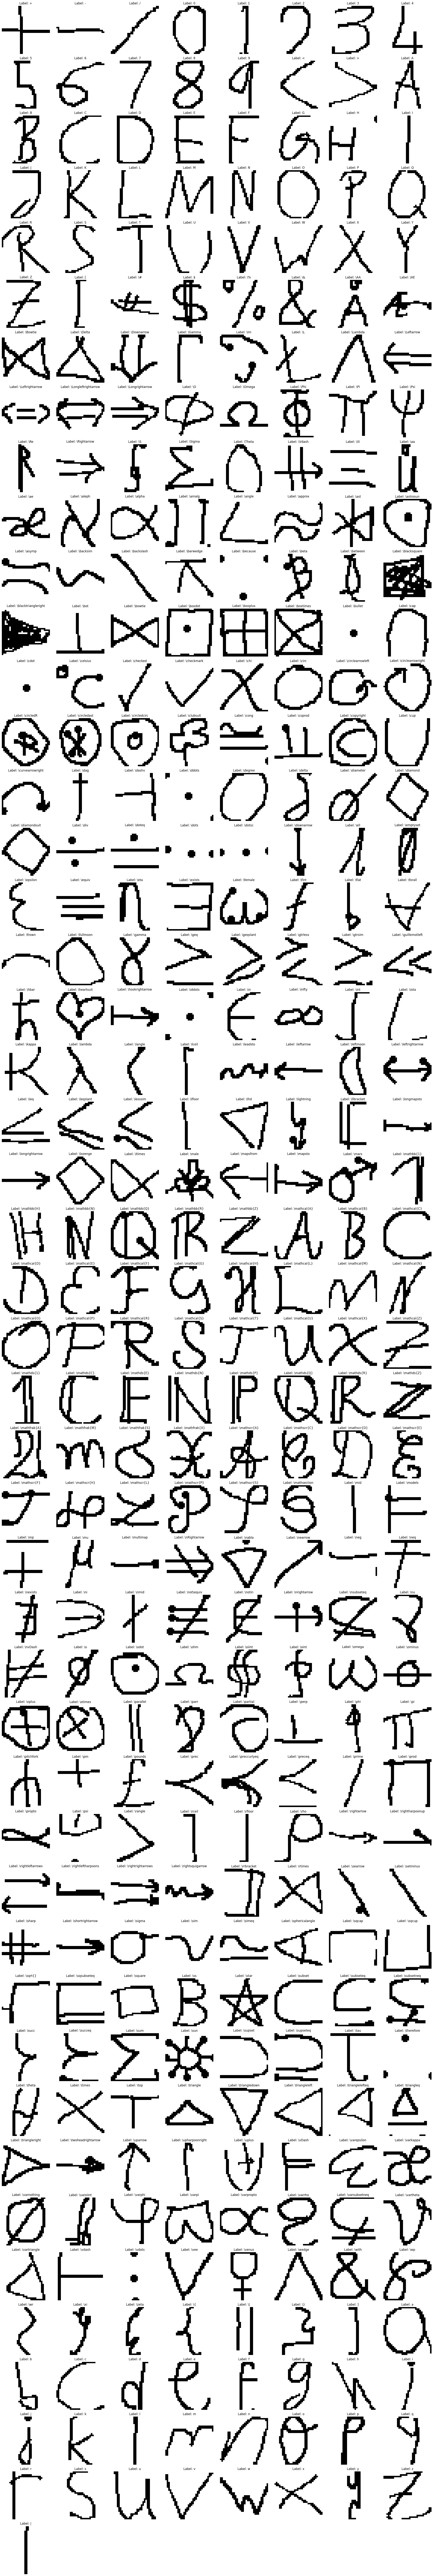

In [52]:
def show_grayscale_samples(dataset, max_cols=8):
    labels = [label for (_, label) in dataset]
    unique_labels = np.unique(labels)
    
    # Grid setup
    ncols = min(len(unique_labels), max_cols)
    nrows = math.ceil(len(unique_labels) / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(3*ncols, 3*nrows))
    axes = axes.flatten()
    
    for ax, lbl in zip(axes, unique_labels):
        idx = random.choice([i for i, label in enumerate(labels) if label == lbl])
        sample, _ = dataset[idx]
        
        # Convert to numpy and remove channel dim (1,32,32) -> (32,32)
        img = sample.numpy() if hasattr(sample, 'numpy') else sample
        ax.imshow(img, cmap='gray')  # Force grayscale
        ax.set_title(f"Label: {lbl}")
        ax.axis('off')
    
    # Hide unused axes
    for ax in axes[len(unique_labels):]:
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

show_grayscale_samples(dataset)

In [55]:
Latex_labels_to_keep = ['+', '-', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '<', '>', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\%', '\\Delta', '\\Gamma', '\\Lambda', '\\Leftarrow', '\\Longleftrightarrow', '\\Longrightarrow', '\\Omega', '\\Phi', '\\Pi', '\\Psi', '\\Sigma', '\\theta', '\\alpha', '\\approx', '\\beta', '\\cap', '\\cdot', '\\checkmark', '\\cong', '\\cup', '\\degree', '\\div', '\\ell', '\\emptyset', '\\epsilon', '\\equiv', '\\eta', '\\exists', '\\forall', '\\gamma', '\\geq', '\\geqslant', '\\in', '\\infty', '\\int', '\\lambda', '\\leftarrow', '\\leftrightarrow', '\\leq', '\\leqslant', '\\longrightarrow', '\\mathbb{N}', '\\mathbb{Q}', '\\mathbb{R}', '\\mathbb{Z}', '\\mid', '\\mu', '\\neq', '\\nexists', '\\ni', '\\not\\equiv', '\\notin', '\\nu', '\\parallel', '\\perp', '\\pi', '\\pm', '\\psi', '\\rightarrow', '\\sigma', '\\simeq', '\\sqrt{}', '\\subset', '\\times', '\\varphi', '\\{', '\\}', ']', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 'u', 'v', 'w', 'x', 'y', 'z']

In [57]:
def filter_dataset_by_labels(dataset, allowed_labels):
    allowed_labels_set = set(allowed_labels)
    filtered_data = [(img_path, label) for img_path, label in dataset.data if label in allowed_labels_set]

    class FilteredHasyV2Dataset(Dataset):
        def __init__(self, data, image_dir, transform=None):
            self.data = data
            self.image_dir = image_dir
            self.transform = transform

        def __len__(self):
            return len(self.data)

        def __getitem__(self, idx):
            img_path, label = self.data[idx]
            full_path = os.path.join(self.image_dir, img_path)
            img = Image.open(full_path).convert('L')
            if self.transform:
                img = self.transform(img)
            return img, label

    return FilteredHasyV2Dataset(filtered_data, dataset.image_dir, dataset.transform)

cleaned_dataset = filter_dataset_by_labels(dataset, Latex_labels_to_keep)
print(f"{len(dataset)-len(cleaned_dataset)} samples have been removed")
print(f"new dataset has {len(cleaned_dataset)} samples, distributed in {len(Latex_labels_to_keep)} classes")

96695 samples have been removed
new dataset has 71538 samples, distributed in 136 classes


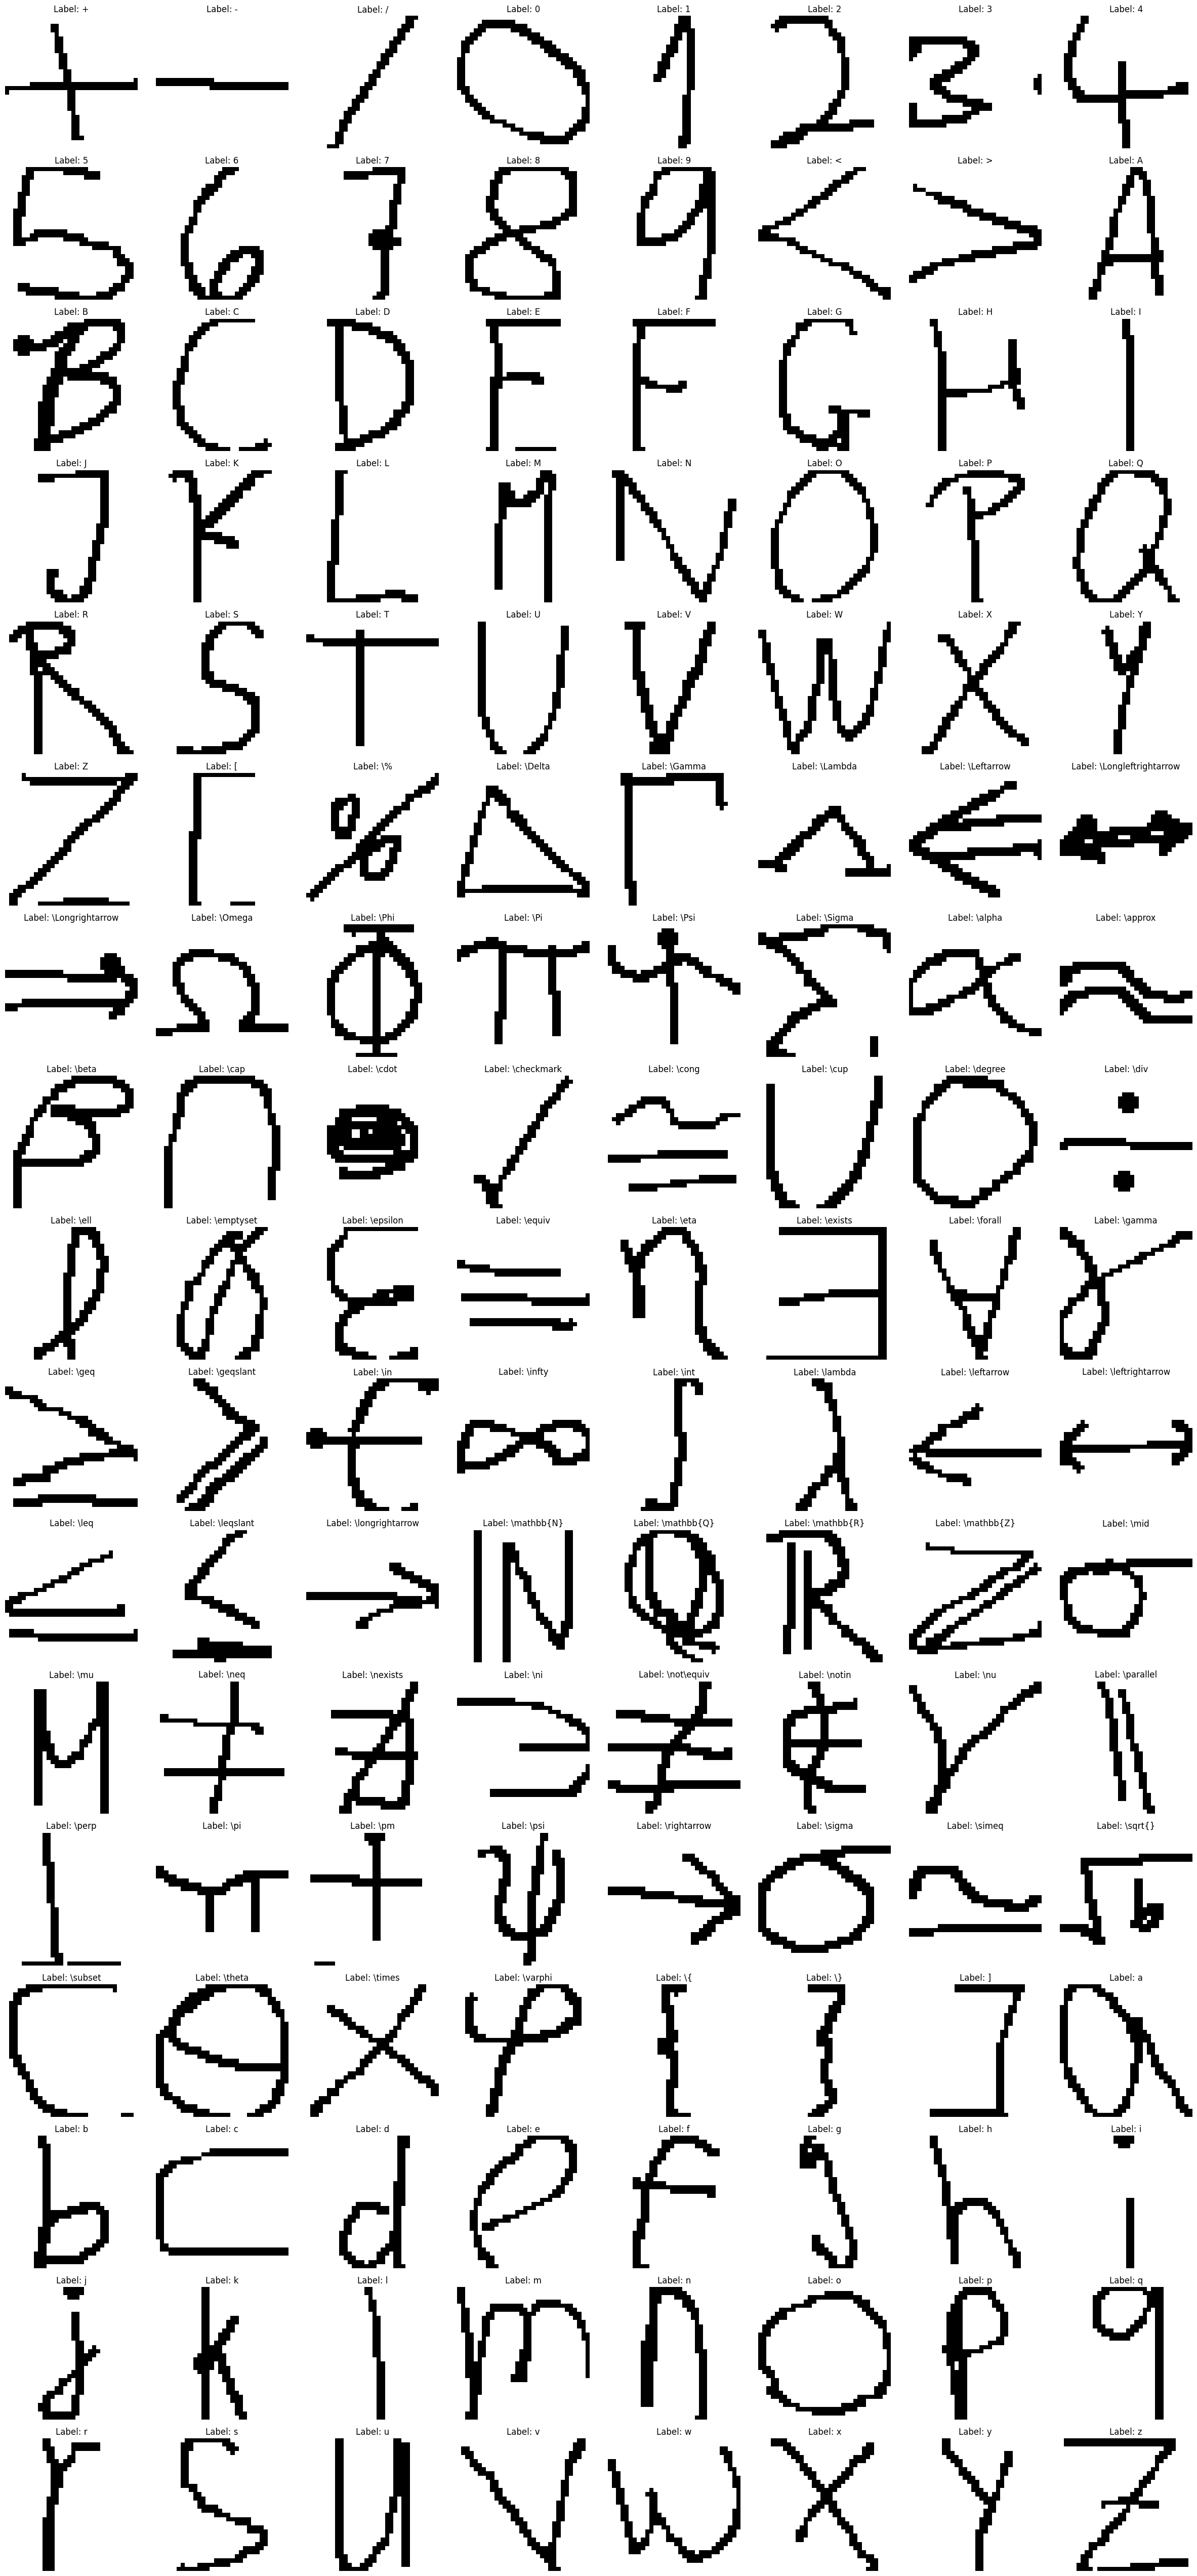

In [58]:
show_grayscale_samples(cleaned_dataset)

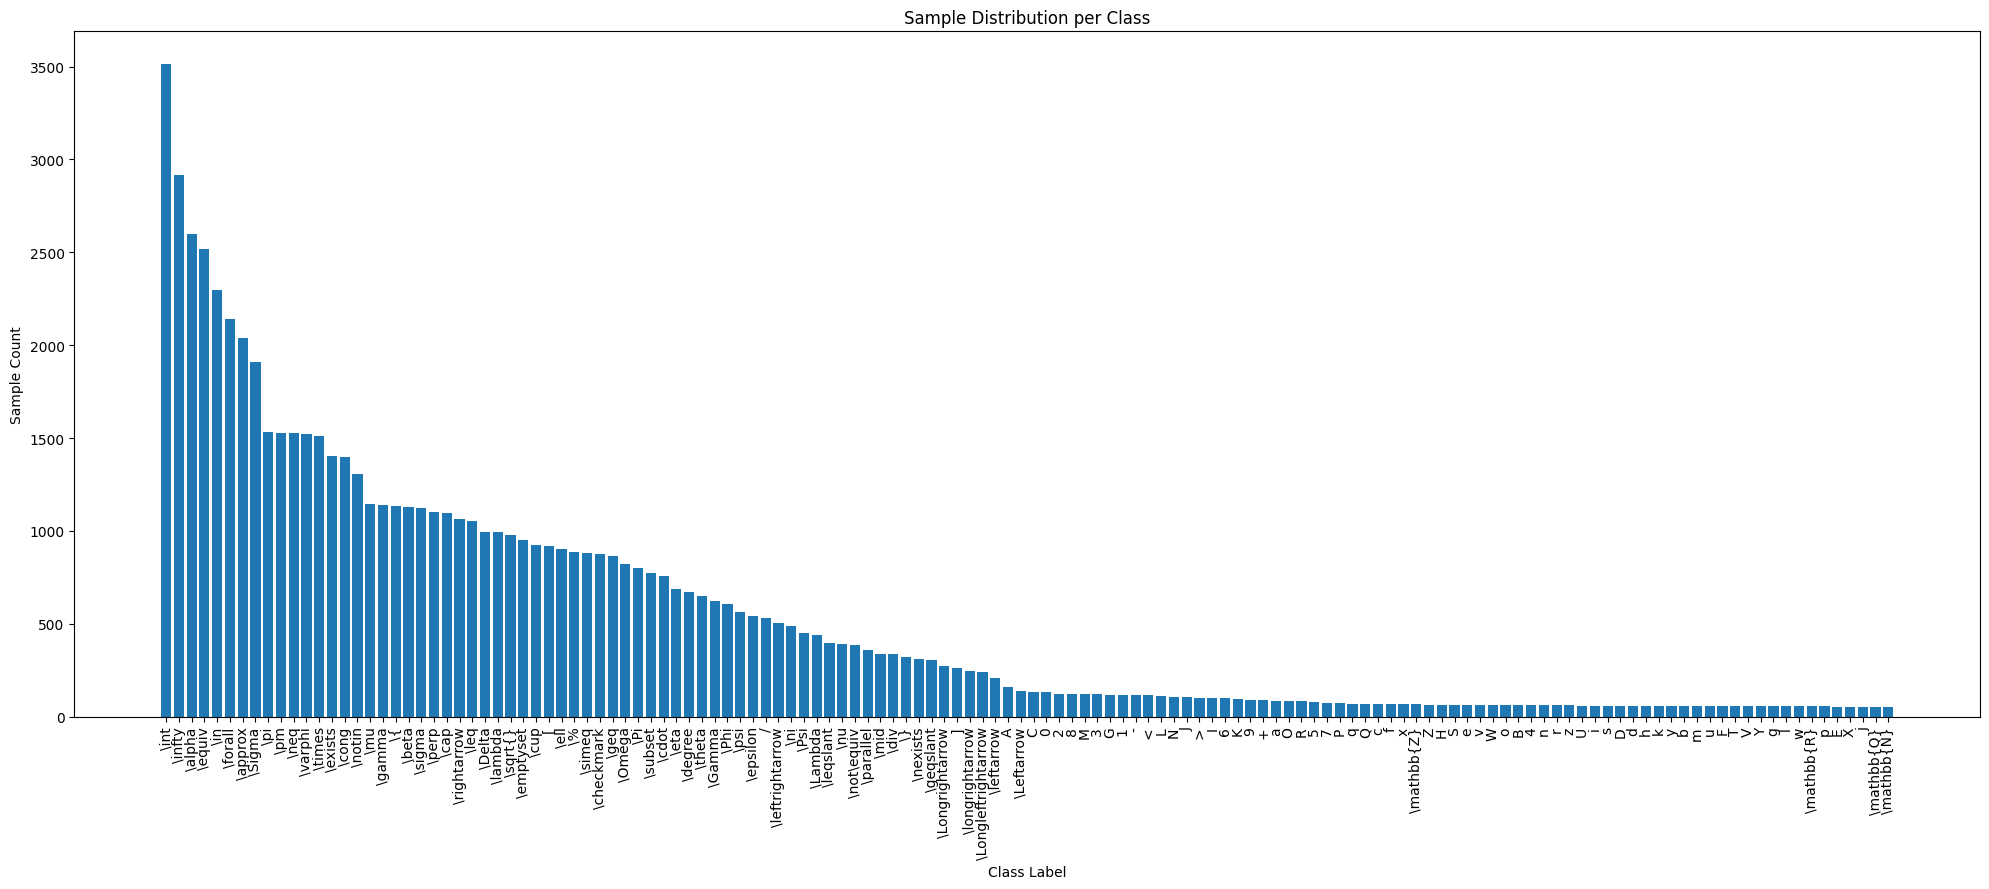


Class Distribution Statistics:
Total classes: 136
Classes with <500 samples: 87 (64.0%)
Classes with >1500 samples: 13 (9.6%)
Most abundant class: 3514 samples
Least abundant class: 51 samples


In [59]:
def plot_class_distribution(dataset):
    labels = [label for _, label in dataset.data]
    counts = Counter(labels)
    total = sum(counts.values())

    # Plot
    labels_sorted = sorted(counts, key=counts.get, reverse=True)
    values = [counts[label] for label in labels_sorted]

    plt.figure(figsize=(20, 9))
    plt.bar(labels_sorted, values)
    plt.xticks(rotation=90)
    plt.xlabel("Class Label")
    plt.ylabel("Sample Count")
    plt.title("Sample Distribution per Class")
    plt.tight_layout()
    plt.show()

    above_1500 = sum(1 for c in counts.values() if c > 1500)
    under_500 = sum(1 for c in counts.values() if c < 500)

    print(f"\nClass Distribution Statistics:")
    print(f"Total classes: {len(Latex_labels_to_keep)}")
    print(f"Classes with <500 samples: {under_500} ({under_500/len(Latex_labels_to_keep):.1%})")
    print(f"Classes with >1500 samples: {above_1500} ({above_1500/len(Latex_labels_to_keep):.1%})")
    print(f"Most abundant class: {max(counts.values())} samples")
    print(f"Least abundant class: {min(counts.values())} samples")
plot_class_distribution(cleaned_dataset)

##### we will use data augmentation to expand our data to have a min of 500 samples per class using ElasticTransform + RandomRotation. then we will downsample over-sampled class to a maximum of 2000 per class

In [93]:
class ElasticTransform:
    def __init__(self, alpha=10, sigma=4):
        self.alpha = alpha
        self.sigma = sigma

    def __call__(self, image):
        # Convert PIL Image to numpy array
        if isinstance(image, Image.Image):
            image = np.array(image)

        if image.ndim == 3:
            h, w, c = image.shape
        else:
            h, w = image.shape
            c = 1
            image = image[:, :, np.newaxis]

        # Your existing code here...
        dx = cv2.GaussianBlur((np.random.rand(h, w) * 2 - 1).astype(np.float32), (0, 0), self.sigma) * self.alpha
        dy = cv2.GaussianBlur((np.random.rand(h, w) * 2 - 1).astype(np.float32), (0, 0), self.sigma) * self.alpha

        x, y = np.meshgrid(np.arange(w), np.arange(h))
        map_x = (x + dx).astype(np.float32)
        map_y = (y + dy).astype(np.float32)

        distorted = np.zeros_like(image)
        for i in range(c):
            distorted[:, :, i] = cv2.remap(image[:, :, i], map_x, map_y, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)

        distorted = distorted if c > 1 else distorted[:, :, 0]

        # Convert back to PIL Image
        if distorted.dtype != np.uint8:
            distorted = np.clip(distorted, 0, 255).astype(np.uint8)
        return Image.fromarray(distorted)

In [98]:
augmentation_pipeline = transforms.Compose([
    transforms.RandomRotation(degrees=10, fill=255),
    ElasticTransform(alpha=10, sigma=4)
])

In [99]:
class AugmentDataset(Dataset):
    def __init__(self, base_images, base_labels, transform, augment_pipeline, k):
        self.base_images = base_images
        self.base_labels = base_labels
        self.transform = transform
        self.augment_pipeline = augment_pipeline
        self.k = k

    def __len__(self):
        return len(self.base_images) * (1 + self.k)

    def __getitem__(self, idx):
        base_idx = idx // (1 + self.k)
        aug_idx = idx % (1 + self.k)

        img = self.base_images[base_idx].copy()
        label = self.base_labels[base_idx]

        if aug_idx == 0:
            if self.transform:
                img = self.transform(img)
        else:
            if self.augment_pipeline:
                img = self.augment_pipeline(img)
            if self.transform:
                img = self.transform(img)

        return img, label

base_images = [cleaned_dataset[i][0] for i in range(len(cleaned_dataset))]
base_labels = [cleaned_dataset[i][1] for i in range(len(cleaned_dataset))]

expanded_dataset = AugmentDataset(
    base_images=base_images,
    base_labels=base_labels,
    transform=ToTensor(),
    augment_pipeline=augmentation_pipeline,
    k=9
)

print("\nExpansion results:")
print(f"Original dataset size: {len(cleaned_dataset)}")
print(f"Expanded dataset size: {len(expanded_dataset)}")
print(f"Total samples added: {len(expanded_dataset) - len(cleaned_dataset)}")


Expansion results:
Original dataset size: 71538
Expanded dataset size: 715380
Total samples added: 643842


In [100]:
expanded_dataset[0]

(tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]),
 'A')


LaTeX Label Verification:
Sample 583280:
  LaTeX label: \forall
  Tensor shape: torch.Size([1, 32, 32])


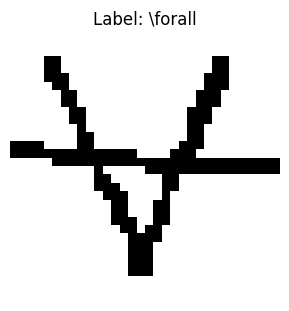

In [120]:
def verify_latex_labels(dataset, num_samples=1):
    import random
    import matplotlib.pyplot as plt
    import torch

    print("\nLaTeX Label Verification:")
    indices = random.sample(range(len(dataset)), num_samples)
    for idx in indices:
        img, latex_label = dataset[idx]
        print(f"Sample {idx}:")
        print(f"  LaTeX label: {latex_label}")
        if isinstance(img, torch.Tensor):
            print(f"  Tensor shape: {img.shape}")
            np_img = img.squeeze(0).numpy()
        else:
            print(f"  Image size: {img.size}")
            np_img = np.array(img)

        plt.figure(figsize=(3.5, 3.5))
        plt.imshow(np_img, cmap='gray')
        plt.title(f"Label: {latex_label}")
        plt.axis('off')
        plt.show()

verify_latex_labels(expanded_dataset)

In [117]:
def downsample_classes(dataset, max_per_class):
    class_to_indices = defaultdict(list)
    for i in range(len(dataset)):
        _, label = dataset[i]    # ensure __getitem__ returns (img, label)
        class_to_indices[label].append(i)
    
    selected_indices = []
    for label, indices in class_to_indices.items():
        if len(indices) > max_per_class:
            selected_indices.extend(random.sample(indices, max_per_class))
        else:
            selected_indices.extend(indices)
    
    subset = torch.utils.data.Subset(dataset, selected_indices)
    return subset

balanced_dataset = downsample_classes(expanded_dataset, max_per_class=2000)
print("\nDownsampling results:")
print(f"Original dataset size: {len(expanded_dataset)}")
print(f"New dataset size: {len(balanced_dataset)}")
print(f"Total samples removed: {len(expanded_dataset) - len(balanced_dataset)}")



Downsampling results:
Original dataset size: 715380
New dataset size: 186470
Total samples removed: 528910


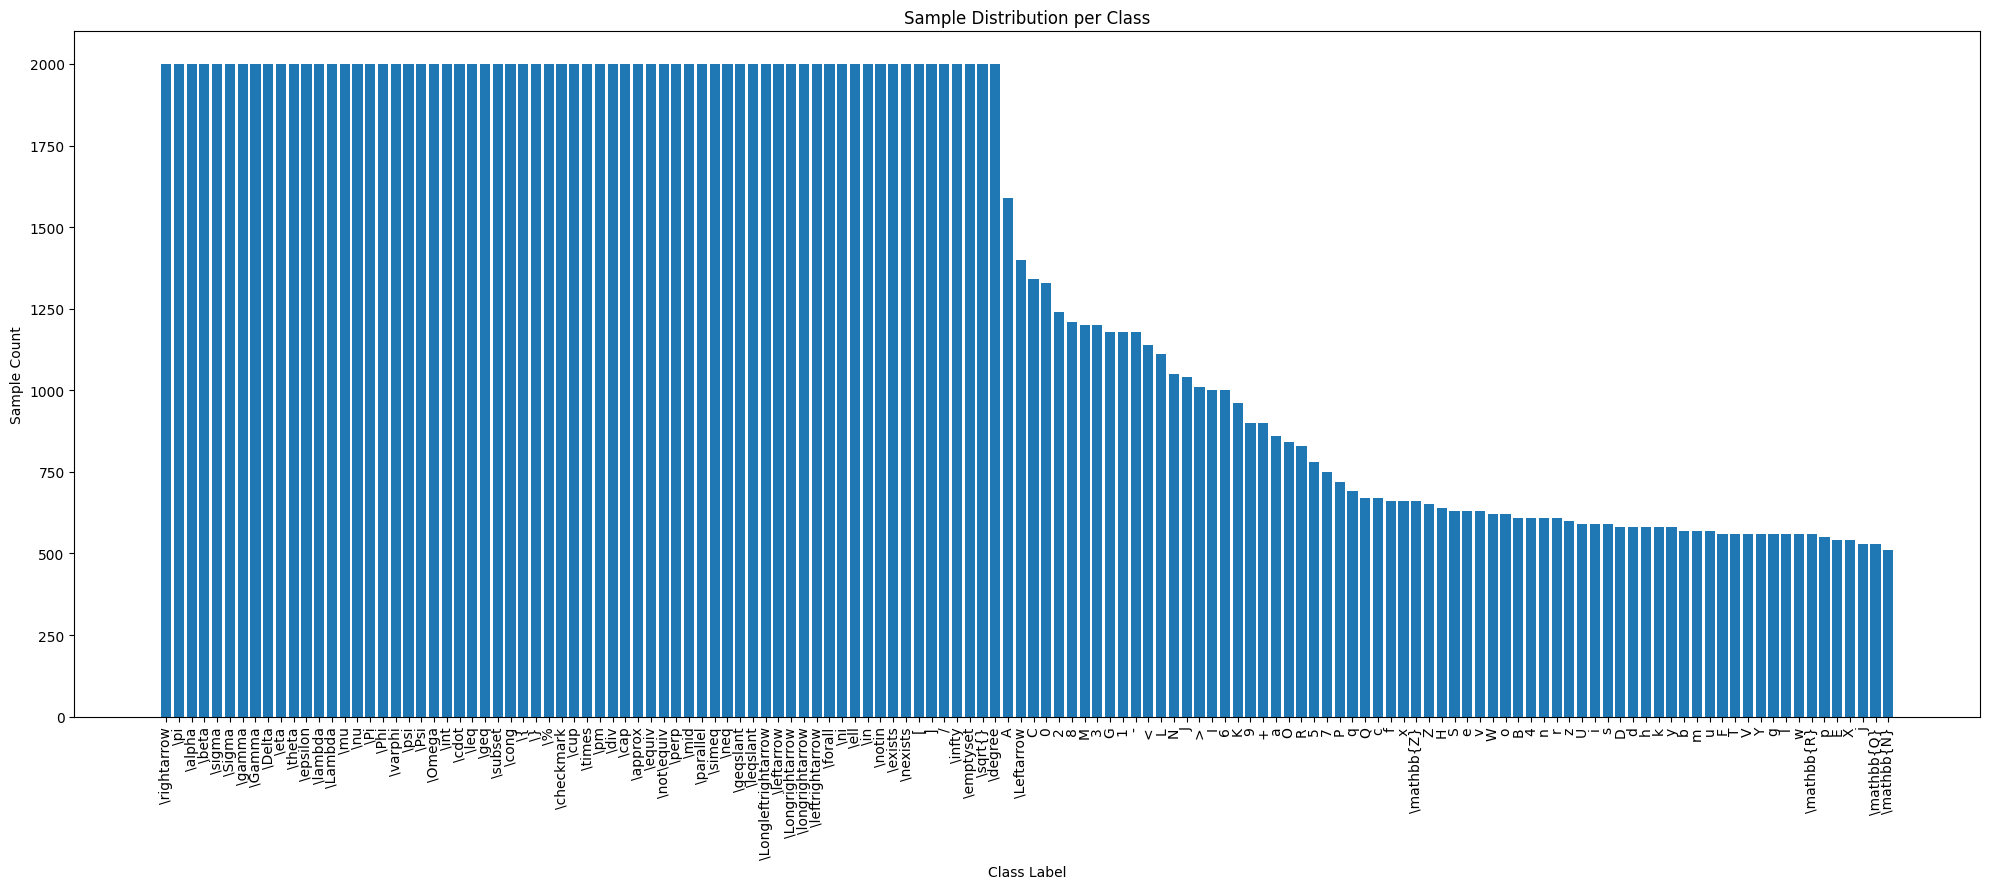


Class Distribution Statistics:
Total classes: 136
Classes with 1000 samples: 52 (38.2%)
Classes with >1500 samples: 67 (49.3%)
Most abundant class: 2000 samples
Least abundant class: 510 samples


In [122]:
def plot_class_distribution_post_augmentation(dataset):
    labels = [label for _, label in dataset]
    counts = Counter(labels)
    total = sum(counts.values())

    # Plot
    labels_sorted = sorted(counts, key=counts.get, reverse=True)
    values = [counts[label] for label in labels_sorted]

    plt.figure(figsize=(20, 9))
    plt.bar(labels_sorted, values)
    plt.xticks(rotation=90)
    plt.xlabel("Class Label")
    plt.ylabel("Sample Count")
    plt.title("Sample Distribution per Class")
    plt.tight_layout()
    plt.show()

    above_1500 = sum(1 for c in counts.values() if c > 1500)
    under_1000 = sum(1 for c in counts.values() if c < 1000)

    print(f"\nClass Distribution Statistics:")
    print(f"Total classes: {len(Latex_labels_to_keep)}")
    print(f"Classes with 1000 samples: {under_1000} ({under_1000/len(Latex_labels_to_keep):.1%})")
    print(f"Classes with >1500 samples: {above_1500} ({above_1500/len(Latex_labels_to_keep):.1%})")
    print(f"Most abundant class: {max(counts.values())} samples")
    print(f"Least abundant class: {min(counts.values())} samples")
plot_class_distribution_post_augmentation(balanced_dataset)

In [132]:
unique_values = torch.unique(torch.cat([img.flatten() for img, _ in balanced_dataset]))
print(unique_values)

tensor([0.0000, 0.0039, 0.0078, 0.0118, 0.0157, 0.0196, 0.0235, 0.0275, 0.0314,
        0.0353, 0.0392, 0.0431, 0.0471, 0.0510, 0.0549, 0.0588, 0.0627, 0.0667,
        0.0706, 0.0745, 0.0784, 0.0824, 0.0863, 0.0902, 0.0941, 0.0980, 0.1020,
        0.1059, 0.1098, 0.1137, 0.1176, 0.1216, 0.1255, 0.1294, 0.1333, 0.1373,
        0.1412, 0.1451, 0.1490, 0.1529, 0.1569, 0.1608, 0.1647, 0.1686, 0.1725,
        0.1765, 0.1804, 0.1843, 0.1882, 0.1922, 0.1961, 0.2000, 0.2039, 0.2078,
        0.2118, 0.2157, 0.2196, 0.2235, 0.2275, 0.2314, 0.2353, 0.2392, 0.2431,
        0.2471, 0.2510, 0.2549, 0.2588, 0.2627, 0.2667, 0.2706, 0.2745, 0.2784,
        0.2824, 0.2863, 0.2902, 0.2941, 0.2980, 0.3020, 0.3059, 0.3098, 0.3137,
        0.3176, 0.3216, 0.3255, 0.3294, 0.3333, 0.3373, 0.3412, 0.3451, 0.3490,
        0.3529, 0.3569, 0.3608, 0.3647, 0.3686, 0.3725, 0.3765, 0.3804, 0.3843,
        0.3882, 0.3922, 0.3961, 0.4000, 0.4039, 0.4078, 0.4118, 0.4157, 0.4196,
        0.4235, 0.4275, 0.4314, 0.4353, 

In [133]:
# Compute global mean and std
all_imgs = torch.stack([img for img, _ in balanced_dataset])
mean = all_imgs.mean()
std = all_imgs.std()

normalized_dataset = [((img - mean) / std, label) for img, label in balanced_dataset]

In [134]:
unique_values = torch.unique(torch.cat([img.flatten() for img, _ in normalized_dataset]))
print(unique_values)

tensor([-2.6472e+00, -2.6350e+00, -2.6228e+00, -2.6106e+00, -2.5984e+00,
        -2.5862e+00, -2.5740e+00, -2.5618e+00, -2.5497e+00, -2.5375e+00,
        -2.5253e+00, -2.5131e+00, -2.5009e+00, -2.4887e+00, -2.4765e+00,
        -2.4643e+00, -2.4521e+00, -2.4399e+00, -2.4277e+00, -2.4155e+00,
        -2.4033e+00, -2.3911e+00, -2.3790e+00, -2.3668e+00, -2.3546e+00,
        -2.3424e+00, -2.3302e+00, -2.3180e+00, -2.3058e+00, -2.2936e+00,
        -2.2814e+00, -2.2692e+00, -2.2570e+00, -2.2448e+00, -2.2326e+00,
        -2.2204e+00, -2.2083e+00, -2.1961e+00, -2.1839e+00, -2.1717e+00,
        -2.1595e+00, -2.1473e+00, -2.1351e+00, -2.1229e+00, -2.1107e+00,
        -2.0985e+00, -2.0863e+00, -2.0741e+00, -2.0619e+00, -2.0497e+00,
        -2.0376e+00, -2.0254e+00, -2.0132e+00, -2.0010e+00, -1.9888e+00,
        -1.9766e+00, -1.9644e+00, -1.9522e+00, -1.9400e+00, -1.9278e+00,
        -1.9156e+00, -1.9034e+00, -1.8912e+00, -1.8790e+00, -1.8669e+00,
        -1.8547e+00, -1.8425e+00, -1.8303e+00, -1.8

In [136]:
torch.save(normalized_dataset, "preprocessed_dataset.pt")